# **Topic Modeling and Search with Top2Vec :** 
# **Universal Studios Singapore**

# **1. Import and Setup**

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import sys
sys.path.append('/content/gdrive/My Drive/nlp')

## **a) To install Top2Vec library and pre-trained BERT sentence transformer options:**

In [ ]:
# !pip install top2vec[sentence_transformers]
!pip install pynndescent

from top2vec import Top2Vec 


## **b) Import Libraries**

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# **2. Import Dataset**

In [9]:
df = pd.read_excel("/content/gdrive/MyDrive/data/clean/formatted_reviews.xlsx")
df.tail(4)

,date,source,attraction,reviews,rating
4595,2018.0,klook,adventure_cove,sangat menyenangkan berbeda dengan waterpark l...,10.0
4596,2018.0,klook,adventure_cove,tempatnya sangat bagusdan permainannya sangat ...,10.0
4597,2018.0,klook,adventure_cove,bagus permainan airnya anak saya suka sekali k...,10.0
4598,2017.0,klook,adventure_cove,pengalaman menyenangkan beli tiket melalui klo...,10.0


In [10]:
uss_df = df[df['attraction'] == 'uss']
uss_df = uss_df.sort_values(by=['date','rating'],ascending=[False,False])
# resetting index
uss_df = uss_df.reset_index(drop=True)
uss_df.tail(4)

,date,source,attraction,reviews,rating
3013,2017.0,traveloka,uss,biasa saja untuk permainan yang menantang sang...,6.0
3014,2017.0,traveloka,uss,biasa saja banyak permainan yang sama di setia...,6.0
3015,2017.0,traveloka,uss,kebetulan pada saat kunjungan hujan penggunaan...,6.0
3016,2017.0,tripadvisor,uss,cocok untuk remaja visit ke atraksi di uss seb...,6.0


In [11]:
uss_docs = uss_df.loc[:, "reviews"].astype(str).values.tolist()
uss_docs[:7]

['luas bangetbanyak spot fotonyawahananya keren',
 'tempat yang wajib dikunjungi ketika ke singapura',
 'good banyak spot fotonyatempat shalatnya sebelah mana iya',
 'seruuu gaeeessss meegilan',
 'tempat yang sangat bagus untuk berlibur saya sangat suka dan puas',
 'wahananya sport jantung semua',
 'lokasinya sangat strategis untuk berwisata berbagai macam wahana yang disediakan dan sangat menghibur mulai dari photo booth bersama beberapa karakter film dari universal studio sampai berbagai macam atraksi yang harus di kunjungi seperti the mummy transformers dan galactica']

# **3. Create and Train N-Gram model (Bi-Gram and Tri-Gram)**
* Top2Vec uses Gensim **simple_preprocess** to do tokenization. 
* To create Trigrams and Bigrams, pass a customized tokenizer into Top2Vec tokenizer parameter. 
* Use Gensim to train this N-gram model. Documents passed to the Phrases function for it to inspect text corpus for N-grams.

In [12]:
import gensim
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import strip_tags

# Build the bigram and trigram models 
sentence_stream = [doc.split(" ") for doc in uss_docs]
bigram = Phrases(sentence_stream, min_count=5, threshold=5, delimiter=b' ')
trigram = Phrases(bigram[sentence_stream], threshold=5, delimiter=b' ')

bigram_phraser = Phraser(bigram)
trigram_phraser = Phraser(trigram)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [13]:
# Create Bi-Grams
def bi_gram(doc):
    sentence_stream = simple_preprocess(strip_tags(str(doc)), deacc=True)
    return bigram_phraser[sentence_stream] 


# Create Bi-Grams and Tri-Grams
def tri_gram(doc):
    sentence_stream = simple_preprocess(strip_tags(str(doc)), deacc=True)
    gen_bigram = bigram_phraser[sentence_stream]
    gen_trigram = trigram_phraser[bigram_phraser[sentence_stream]]
    return gen_trigram

# **4. Train Top2Vec Model**

### **Parameters**:
* **Documents**: Input corpus, should be a list of strings.
* **Min_count**: (Optional, default 50) Ignores all words with total frequency lower than this. For smaller corpora a smaller min_count will be necessary.
* **Embedding_model** (string or callable) – The valid string options are: doc2vec , universal-sentence-encoder , universal-sentence-encoder-multilingual,distiluse-base-multilingual-cased , all-MiniLM-L6-v2 , paraphrase-multilingual-MiniLM-L12-v2 
* **tokenizer** (callable (Optional, default None)) – Override the default tokenization method. If None then gensim.utils.simple_preprocess will be used. ***Tokenizer must take a document and return a list of tokens***.


In [ ]:
# FORM UNI-GRAMS, BI-GRAMS WITH BI-GRAM MODEL 

topicMODEL_bi = Top2Vec(documents= uss_docs, min_count=5, embedding_model = 'distiluse-base-multilingual-cased', tokenizer= bi_gram)  

In [ ]:
# FORM UNI-GRAMS, BI-GRAMS, TRI-GRAMS WITH TRI-GRAM MODEL 
 
topicMODEL_tri = Top2Vec(documents= uss_docs, min_count=5, embedding_model = 'distiluse-base-multilingual-cased', tokenizer = tri_gram)  

In [ ]:
# SAVE MODELS FOR FUTURE USE

topicMODEL_bi.save("/content/gdrive/MyDrive/data/models/bigram_uss_june22")

topicMODEL_tri.save("/content/gdrive/MyDrive/data/models/trigram_uss_june22")

In [14]:
# LOAD MODEL FROM SAVED MODELS

topicMODEL_bi = Top2Vec.load("/content/gdrive/MyDrive/data/models/bigram_uss_june26")

topicMODEL_tri = Top2Vec.load("/content/gdrive/MyDrive/data/models/trigram_uss_june26")

# **5. Perform Topic Reduction** 

* Reduce the number of topics discovered by Top2Vec.
* The most representative topics of the corpus will be found, by iteratively merging each smallest topic to the most similar topic until num_topics is reached. 
* Get the hierarchy of reduced topics. The mapping of each original topic to the reduced topics is returned.

In [15]:
# BI-GRAM MODEL TOPIC REDUCTION
topicMODEL_bi.hierarchical_topic_reduction(num_topics=10) 

topicMODEL_bi.get_topic_hierarchy()

[[0],
 [1],
 [4, 2],
 [5, 21, 7],
 [11, 22, 3],
 [13, 15, 16, 17, 14],
 [12, 20, 8],
 [18, 10],
 [6],
 [19, 9]]

In [16]:
# TRI-GRAM MODEL TOPIC REDUCTION 
topicMODEL_tri.hierarchical_topic_reduction(num_topics=10) 

topicMODEL_tri.get_topic_hierarchy()

[[15, 0],
 [1],
 [5, 2],
 [19, 10, 12, 20, 14],
 [16, 17, 13, 22, 9],
 [11, 23, 4],
 [3],
 [18, 8],
 [21, 7],
 [6]]

# **6. Explore Discovered Topics**

## **6a) Get Number of Topics**
This will return the number of topics that Top2Vec has found in the data.

In [17]:
# Show the Total Number of Topics 

print(f"Total Number of Topics generated (Topic Reduction Applied): \n")
print(f"Bi-gram Model : {topicMODEL_bi.get_num_topics(reduced=True)}")
print(f"Tri-gram Model : {topicMODEL_tri.get_num_topics(reduced=True)}")

Total Number of Topics generated (Topic Reduction Applied): 

Bi-gram Model : 10
Tri-gram Model : 10


## **6b) Get Topic Sizes**
This will return the number of documents most similar to each topic. Topics are in decreasing order of size.

Returns:
* topic_sizes: The number of documents most similar to each topic.
* topic_nums: The unique index of every topic will be returned.

### **6b.1. Bi-Gram and Tri-Gram Model Topic Sizes**

In [18]:
print("BI-GRAM MODEL where N = 1 and 2")
print("================================\n")
topic_sizes_bi, topic_nums_bi = topicMODEL_bi.get_topic_sizes(reduced=True) 

print(f"Unique index numbers of every topic: {topic_nums_bi} ")
print()
print(f"Number of documents for each unique topic: {topic_sizes_bi} \n")

print("TRI-GRAM MODEL where N = 1, 2 and 3")
print("====================================\n")
topic_sizes_tri, topic_nums_tri = topicMODEL_tri.get_topic_sizes(reduced=True) 
print(f"Unique index numbers of every topic: {topic_nums_tri} ")
print()
print(f"Number of documents for each unique topic: {topic_sizes_tri} ") 

BI-GRAM MODEL where N = 1 and 2

Unique index numbers of every topic: [0 1 2 3 4 5 6 7 8 9] 

Number of documents for each unique topic: [562 433 383 275 270 269 226 218 210 171] 

TRI-GRAM MODEL where N = 1, 2 and 3

Unique index numbers of every topic: [0 1 2 3 4 5 6 7 8 9] 

Number of documents for each unique topic: [565 442 390 264 263 250 227 227 195 194] 


## **6c) Get Topics**
This will return the topics in decreasing size.

Returns:

* topic_words: For each topic the top 50 words are returned, in decreasing order of semantic similarity to topic.

* word_scores: For each topic the cosine similarity scores (in decreasing order) of the top 50 words to the topic are returned.

* topic_nums: The unique index of every topic will be returned.

### **c.1.  BI-GRAM Model Topics**

In [19]:
print(f"TOPICS FOR BI-GRAM MODEL: \n")
topic_words_bi, word_scores_bi, topic_nums_bi = topicMODEL_bi.get_topics(topicMODEL_bi.get_num_topics(reduced=True))

for count,(words_bi, scores_bi, num_bi) in enumerate(zip(topic_words_bi, word_scores_bi, topic_nums_bi)):
    print(f"{count+1}. Topic {num_bi+1}") 
    print(f"Topic Words : \n{words_bi} \n")
    # print(f"Cosine Similarity :\n{scores_bi}\n")

TOPICS FOR BI-GRAM MODEL: 

1. Topic 1
Topic Words : 
['print tiket' 'tiket masuknya' 'pembelian tiket' 'tiket express'
 'beli tiketnya' 'membeli tiket' 'tiket masuk' 'ticket' 'ticketing'
 'tiketnya' 'harga tiketnya' 'harga tiket' 'penukaran tiket' 'pesan tiket'
 'scan barcode' 'beli tiket' 'langsung scan' 'tiket' 'barcode langsung'
 'para wisatawan' 'barcode saja' 'express pass' 'print out' 'print'
 'daripada beli' 'tempat wisata' 'scan' 'tunjukkan barcode' 'tinggal scan'
 'train' 'wisatawan' 'destinasi wisata' 'melalui traveloka' 'trip'
 'untuk dikunjungi' 'tukar tiket' 'wisata yang' 'museum' 'beli online'
 'di traveloka' 'beli express' 'agak mahal' 'sangat memudahkan' 'travel'
 'wisata' 'barcode' 'via traveloka' 'lebih murah' 'mengunjungi universal'
 'tujuan wisata'] 

2. Topic 2
Topic Words : 
['studio singapore' 'studio singapura' 'ke singapore' 'singapore'
 'ke singapura' 'singapur' 'di singapura' 'singapura' 'universal studios'
 'universal studio' 'mengunjungi universal' 'di ind

### **c.2. Tri-Gram Model Topics**

In [20]:
print(f"TOPICS FOR TRI-GRAM MODEL : \n")
topic_words_tri, word_scores_tri, topic_nums_tri = topicMODEL_tri.get_topics(topicMODEL_tri.get_num_topics(reduced=True))

for count, (words_tri, scores_tri, num_tri) in enumerate(zip(topic_words_tri, word_scores_tri, topic_nums_tri)):
    print(f"{count+1}. Topic {num_tri+1}") 
    print(f"Topic Words : \n{words_tri}\n")
    # print(f"Cosine Similarity :\n{scores_tri}\n")

TOPICS FOR TRI-GRAM MODEL : 

1. Topic 1
Topic Words : 
['untuk membeli tiket' 'print tiket' 'tiket masuknya' 'dapat tiket'
 'pembelian tiket' 'tiket express' 'beli tiketnya' 'membeli tiket'
 'harga tiket masuk' 'tiket masuk' 'ticket' 'tiket lagi' 'ticketing'
 'beli tiket di traveloka' 'tiketnya' 'beli tiket express'
 'harga tiketnya' 'harga tiket' 'penukaran tiket' 'beli tiket online'
 'langsung scan barcode' 'tinggal scan barcode saja' 'pesan tiket'
 'antri beli tiket' 'beli express pass' 'tinggal scan barcode'
 'scan barcode' 'beli tiket' 'langsung scan' 'beli di traveloka' 'tiket'
 'traveloka sangat membantu' 'barcode langsung' 'para wisatawan'
 'tidak perlu diprint' 'express pass' 'tinggal scan saja'
 'tidak perlu antri beli' 'tunjukkan barcode' 'lebih murah daripada beli'
 'print out' 'beli tiket uss' 'print' 'scan' 'tinggal scan'
 'tempat wisata' 'train' 'wisatawan' 'tempat wisata yang'
 'destinasi wisata']

2. Topic 2
Topic Words : 
['universal studios singapore' 'universal stu

## **6d) Search Documents by Topic**
We are going to search by topic; for example Topic 3. 

Returns:

* documents:  The documents in a list, the most similar are first.
* doc_scores:  Semantic similarity of document to topic. The cosine similarity of the document and topic vector.
* doc_ids:  Unique ids of documents. If ids were not given, the index of document in the original corpus.

For each of the returned documents we are going to print its content, score and document number.

### **d.1. Search Documents By Topic Number Using Bi-Gram Model**

In [21]:
# SEARCH DOCUMENTS BY TOPIC NUMBER USING BI-GRAM MODEL 
topic_num_bi = 9
documents_bi, document_scores_bi, document_ids_bi = topicMODEL_bi.search_documents_by_topic(topic_num= topic_num_bi , num_docs= 5, reduced=True) 

print(f"TOPIC NUMBER: {topic_num_bi}\n")
for count, (doc_bi, docscore_bi, doc_id_bi) in enumerate(zip(documents_bi, document_scores_bi, document_ids_bi)):
    print(f"{count}. Document: {doc_id_bi},  Score: {docscore_bi}")
    print("-----------")
    print(doc_bi)
    print("-----------\n")

TOPIC NUMBER: 9

0. Document: 2971,  Score: 0.6269163489341736
-----------
good destination for kids we all enjoy it
-----------

1. Document: 662,  Score: 0.6016066074371338
-----------
awesome experience my children loved it so much
-----------

2. Document: 2197,  Score: 0.5742599368095398
-----------
anak saya sangat enjoy di universal tapi karena kami pergi pas liburan bahkan antrinya banyak orang mainan outdoor juga menyenangkan sipp deh pokoknya
-----------

3. Document: 1820,  Score: 0.5724554061889648
-----------
menyenangkan dan anak saya sangat antusias untuk mencoba semua permainan
-----------

4. Document: 2053,  Score: 0.5597842335700989
-----------
menyenangkan anakanak sangat gembira cuman kenapa pas liburan antrian permainannya lumayan lama dan panjang
-----------



In [ ]:
uss_df.iloc[[1123]]

,date,source,attraction,reviews,rating
1123,2019.0,google_reviews,uss,bersih dan menyenangkan banyak permainan2 yang...,10.0


### **d.2. Search Documents By Topic Number Using Tri-Gram Model**

In [22]:
# SEARCH DOCUMENTS BY TOPIC NUMBER USING TRI-GRAM MODEL 
topic_num_tri = 5
documents_tri, document_scores_tri, document_ids_tri = topicMODEL_tri.search_documents_by_topic(topic_num= topic_num_tri, num_docs= 5, reduced=True) 
print(f"TOPIC NUMBER: {topic_num_bi}\n")
for count, (doc_tri, docscore_tri, doc_id_tri) in enumerate(zip(documents_tri, document_scores_tri, document_ids_tri)):
    print(f"{count}. Document: {doc_id_tri},  Score: {docscore_tri}")
    print("-----------")
    print(doc_tri)
    print("-----------\n")

TOPIC NUMBER: 9

0. Document: 2277,  Score: 0.49599558115005493
-----------
we had a great time lanjut time will go again
-----------

1. Document: 1849,  Score: 0.48642441630363464
-----------
amazing lanjut time akan ke sini lagi
-----------

2. Document: 2826,  Score: 0.4529438614845276
-----------
very good will definitely go back
-----------

3. Document: 2207,  Score: 0.43142038583755493
-----------
menyenangkan semoga bisa kembali lagi kesini
-----------

4. Document: 2818,  Score: 0.4268704056739807
-----------
good fun gak ragu buat dateng kesini lagi
-----------



In [ ]:
uss_df.iloc[[794]]

,date,source,attraction,reviews,rating
794,2020.0,traveloka,uss,sangat bagus cuma jangan datang waktu weekend ...,8.0


# **7) Constructing Dataframe to Collate Information of Key Topics**

## **7a) BI-GRAM MODEL**

In [23]:
# CONSTRUCT DATAFRAME OF BI-GRAM MODEL WITH KEY INFORMATION FOR EXPORT
# initialize data of lists.
bigram_table = {
              'topic number': [num_bi for num_bi in topic_nums_bi],
              'topic words': [words_bi for words_bi in topic_words_bi],
              'cosine similarity metrics': [scores_bi for scores_bi in word_scores_bi],
              'similar documents': [size_bi for size_bi in topic_sizes_bi],
               }
 
# Create DataFrame
bigram_df = pd.DataFrame(bigram_table)
bigram_df['topic number'] = bigram_df['topic number'].apply(lambda x: x + 1)

# print(bigram_df.head(2))
bigram_df.tail(3)

,topic number,topic words,cosine similarity metrics,similar documents
7,8,"[sangat menyenangkan, menyenangkan sekali, san...","[0.8143233, 0.7388338, 0.71513903, 0.71454847,...",218
8,9,"[amazing place, nice place, tempatnya bagus, g...","[0.8008571, 0.7981447, 0.77436125, 0.7580141, ...",210
9,10,"[anakanak senang, anak kecil, untuk anak, sang...","[0.41698378, 0.31886488, 0.2953571, 0.295102, ...",171


### **7a.1. Build Functions to Expand Column Features in Bi-Gram Dataframe**

In [24]:
def get_document_index(topic_num_bi, num_doc):
    documents_bi, document_scores_bi, document_ids_bi = topicMODEL_bi.search_documents_by_topic(topic_num= topic_num_bi , num_docs= num_doc, reduced=True)
    document_index = [doc_id_bi for doc_id_bi in document_ids_bi]
    return document_index 

def get_document_scores(topic_num_bi, num_doc):
    documents_bi, document_scores_bi, document_ids_bi = topicMODEL_bi.search_documents_by_topic(topic_num= topic_num_bi , num_docs= num_doc, reduced=True)
    document_scores = [docscore_bi for docscore_bi in document_scores_bi]
    return document_scores


def get_documents(topic_num_bi, num_doc):
    documents_bi, document_scores_bi, document_ids_bi = topicMODEL_bi.search_documents_by_topic(topic_num= topic_num_bi , num_docs= num_doc, reduced=True)
    actual_document = [doc_bi for doc_bi in documents_bi]
    return actual_document


In [32]:
bigram_df['document index'] = bigram_df['topic number'].apply(lambda x: get_document_index(x-1, bigram_df['similar documents'].values[x-1]))

bigram_df['document scores'] = bigram_df['topic number'].apply(lambda x: get_document_scores(x-1, bigram_df['similar documents'].values[x-1]))

bigram_df['actual reviews'] = bigram_df['topic number'].apply(lambda x: get_documents(x-1, bigram_df['similar documents'].values[x-1]))


# bigram_df = bigram_df.drop(['topic label'], axis = 1)
bigram_df.tail(4)

,topic number,topic words,cosine similarity metrics,similar documents,document index,document scores,actual reviews
6,7,"[seneng banget, wahananya seru, puas banget, s...","[0.6907344, 0.6872061, 0.6514802, 0.62032145, ...",226,"[1545, 1244, 2961, 2052, 2291, 1934, 1764, 260...","[0.6729108, 0.61876476, 0.60831153, 0.59375393...","[good place for fun there we was enjoy it, goo..."
7,8,"[sangat menyenangkan, menyenangkan sekali, san...","[0.8143233, 0.7388338, 0.71513903, 0.71454847,...",218,"[2867, 3000, 2048, 2091, 794, 778, 185, 2170, ...","[0.55410093, 0.5444857, 0.53786, 0.5104105, 0....",[that was fun although we belum ride the rapid...
8,9,"[amazing place, nice place, tempatnya bagus, g...","[0.8008571, 0.7981447, 0.77436125, 0.7580141, ...",210,"[1305, 987, 2583, 198, 2570, 239, 1018, 619, 2...","[0.46093345, 0.44408453, 0.43693182, 0.4237161...","[wajib naik transformers, waduh capek bangetlu..."
9,10,"[anakanak senang, anak kecil, untuk anak, sang...","[0.41698378, 0.31886488, 0.2953571, 0.295102, ...",171,"[2971, 662, 2197, 1820, 2053, 1939, 2260, 2313...","[0.62691635, 0.6016066, 0.57425994, 0.5724554,...","[good destination for kids we all enjoy it, aw..."


In [26]:
# for count, (index, review) in enumerate(zip(bigram_df['document index'][28], bigram_df['actual reviews'][28])):
#   print(f"{count}: {index} = {review})")

bigram_df.to_excel(f'/content/gdrive/MyDrive/data/export/bigram_df_ussR.xlsx', index=False)

## **7b) TRI-GRAM MODEL**

In [27]:
# CONSTRUCT DATAFRAME CONTAINING KEY INFORMATION FOR EXPORT
# initialize data of lists.
trigram_table = {
                'topic number': [num_tri for num_tri in topic_nums_tri],
                'topic words': [words_tri for words_tri in topic_words_tri],
                'cosine similarity metrics': [scores_tri for scores_tri in word_scores_tri],
                'similar documents': [size_tri for size_tri in topic_sizes_tri],
                 }

# Create DataFrame
trigram_df = pd.DataFrame(trigram_table)

trigram_df['topic number'] = trigram_df['topic number'].apply(lambda x: x + 1)
trigram_df.tail(3)

,topic number,topic words,cosine similarity metrics,similar documents
7,8,"[sangat menyenangkan, sangat menikmati, menyen...","[0.8130126, 0.76403177, 0.73942864, 0.7143258,...",227
8,9,"[hari libur, kalau weekend, pas weekend, weeke...","[0.47181985, 0.44380218, 0.44265878, 0.4386118...",195
9,10,"[tempat yang sangat bagus, tempat yang menyena...","[0.89119315, 0.86382794, 0.8293486, 0.8041558,...",194


### **7b.1. Build Functions to Expand Column Features in Tri-Gram Dataframe**

In [28]:
def get_document_index_tri(topic_num_tri, num_docs):
    documents_tri, document_scores_tri, document_ids_tri = topicMODEL_tri.search_documents_by_topic(topic_num= topic_num_tri , num_docs= num_docs, reduced=True)
    document_index = [doc_id_tri for doc_id_tri in document_ids_tri]
    return document_index 

def get_document_scores_tri(topic_num_tri, num_docs):
    documents_tri, document_scores_tri, document_ids_tri = topicMODEL_tri.search_documents_by_topic(topic_num= topic_num_tri , num_docs= num_docs, reduced=True)
    document_scores = [docscore_tri for docscore_tri in document_scores_tri]
    return document_scores


def get_documents_tri(topic_num_tri, num_docs):
    documents_tri, document_scores_tri, document_ids_tri = topicMODEL_tri.search_documents_by_topic(topic_num= topic_num_tri , num_docs= num_docs, reduced=True)
    actual_document = [doc_tri for doc_tri in documents_tri]
    return actual_document


In [31]:
trigram_df['document index'] = trigram_df['topic number'].apply(lambda x: get_document_index_tri(x-1, trigram_df['similar documents'].values[x-1]))

trigram_df['document scores'] = trigram_df['topic number'].apply(lambda x: get_document_scores_tri(x-1, trigram_df['similar documents'].values[x-1]))

trigram_df['actual reviews'] = trigram_df['topic number'].apply(lambda x: get_documents_tri(x-1, trigram_df['similar documents'].values[x-1]))

trigram_df.tail(4)

,topic number,topic words,cosine similarity metrics,similar documents,document index,document scores,actual reviews
6,7,"[banyak wahana permainan, banyak permainan yan...","[0.778923, 0.760726, 0.7392867, 0.7332465, 0.6...",227,"[1305, 2570, 2583, 987, 1018, 1636, 2786, 2537...","[0.4300419, 0.42258707, 0.4201179, 0.41827136,...","[wajib naik transformers, wahhhh sunguh asyik ..."
7,8,"[sangat menyenangkan, sangat menikmati, menyen...","[0.8130126, 0.76403177, 0.73942864, 0.7143258,...",227,"[2867, 3000, 2048, 2091, 794, 778, 2170, 185, ...","[0.5496368, 0.5436169, 0.5399023, 0.51522326, ...",[that was fun although we belum ride the rapid...
8,9,"[hari libur, kalau weekend, pas weekend, weeke...","[0.47181985, 0.44380218, 0.44265878, 0.4386118...",195,"[1586, 1798, 393, 1936, 1639, 1566, 1166, 671,...","[0.75407124, 0.7151545, 0.6769384, 0.6642821, ...","[amazing very fun love it, really nice fun and..."
9,10,"[tempat yang sangat bagus, tempat yang menyena...","[0.89119315, 0.86382794, 0.8293486, 0.8041558,...",194,"[1814, 1462, 1109, 1123, 1820, 2397, 1829, 215...","[0.6433251, 0.5882349, 0.54669315, 0.53018993,...","[super fun always excited in every playground,..."


In [33]:
# for count, (index, review) in enumerate(zip(trigram_df['document index'][0], trigram_df['actual reviews'][0])):
#   print(f"{count}: {index} = {review})")

trigram_df.to_excel(f'/content/gdrive/MyDrive/data/export/trigram_df_ussR.xlsx', index=False)

# **8. Defining Topic Labels on Reviews** 

## **8a) User-Define Topic Labels** 

### **8a.1:  BI-GRAM Model** 

In [35]:
# Create the dictionary containing the data of the new column
bigram_col_dict = { 'Topic 1': 'ticketing',                 'Topic 2': 'must visit place',
                    'Topic 3': 'visitors sentiments',       'Topic 4': 'waiting times',
                    'Topic 5': 'amusement rides',           'Topic 6': 'features visitors like',
                    'Topic 7': 'visitors experiences',       'Topic 8': 'likely to return',
                    'Topic 9': 'vacation choice',           'Topic 10': "great choice for families",
                    
                  }
                   
# Assign the values of the dictionary as the values of the new column
bigram_df['topic label'] = bigram_col_dict.values()
bigram_df

,topic number,topic words,cosine similarity metrics,similar documents,document index,document scores,actual reviews,topic label
0,1,"[print tiket, tiket masuknya, pembelian tiket,...","[0.48053187, 0.4744914, 0.46251032, 0.46125066...",562,"[1766, 1621, 1884, 1430, 781, 685, 1435, 1516,...","[0.71312773, 0.70427847, 0.6966245, 0.6771126,...",[beli tiket melalui traveloka sangat mudah lan...,ticketing
1,2,"[studio singapore, studio singapura, ke singap...","[0.56663513, 0.54078025, 0.46721637, 0.4585612...",433,"[448, 2695, 1616, 462, 2498, 943, 2834, 1105, ...","[0.7394327, 0.72746027, 0.7229265, 0.71766627,...",[universal studio menjadi salah satu destinasi...,must visit place
2,3,"[bawa botol, untuk liburan, agak mahal, sangat...","[0.16208713, 0.14814812, 0.14463222, 0.1359866...",383,"[2527, 766, 2915, 61, 2113, 3010, 459, 1325, 2...","[0.5365477, 0.5324302, 0.52857494, 0.52385193,...",[transformers adalah wahana 3d paling menarik ...,visitors sentiments
3,4,"[terlalu lama, cukup panjang, antrinya lama, a...","[0.56883705, 0.5335444, 0.5201221, 0.51911527,...",275,"[1586, 1936, 1798, 393, 1814, 671, 2062, 1518,...","[0.7099924, 0.70157886, 0.69690484, 0.6641047,...","[amazing very fun love it, there is so much fu...",waiting times
4,5,"[wahana transformer, adalah transformers, tran...","[0.65136987, 0.6080936, 0.6054553, 0.6037128, ...",270,"[2277, 1849, 1914, 2826, 2818, 2297, 679, 2207...","[0.49883634, 0.47006646, 0.4630661, 0.4566642,...",[we had a great time lanjut time will go again...,amusement rides
5,6,"[banyak permainan, wahana permainan, permainan...","[0.73714143, 0.6768937, 0.67639023, 0.62845916...",269,"[2367, 663, 1957, 2862, 1436, 1858, 750, 320, ...","[0.81257033, 0.80215645, 0.76080954, 0.7507382...","[nice place for holiday with family, great pla...",features visitors like
6,7,"[seneng banget, wahananya seru, puas banget, s...","[0.6907344, 0.6872061, 0.6514802, 0.62032145, ...",226,"[1545, 1244, 2961, 2052, 2291, 1934, 1764, 260...","[0.6729108, 0.61876476, 0.60831153, 0.59375393...","[good place for fun there we was enjoy it, goo...",visitors experiences
7,8,"[sangat menyenangkan, menyenangkan sekali, san...","[0.8143233, 0.7388338, 0.71513903, 0.71454847,...",218,"[2867, 3000, 2048, 2091, 794, 778, 185, 2170, ...","[0.55410093, 0.5444857, 0.53786, 0.5104105, 0....",[that was fun although we belum ride the rapid...,likely to return
8,9,"[amazing place, nice place, tempatnya bagus, g...","[0.8008571, 0.7981447, 0.77436125, 0.7580141, ...",210,"[1305, 987, 2583, 198, 2570, 239, 1018, 619, 2...","[0.46093345, 0.44408453, 0.43693182, 0.4237161...","[wajib naik transformers, waduh capek bangetlu...",vacation choice
9,10,"[anakanak senang, anak kecil, untuk anak, sang...","[0.41698378, 0.31886488, 0.2953571, 0.295102, ...",171,"[2971, 662, 2197, 1820, 2053, 1939, 2260, 2313...","[0.62691635, 0.6016066, 0.57425994, 0.5724554,...","[good destination for kids we all enjoy it, aw...",great choice for families


In [36]:
# CREATE COPY OF ORIGINAL DATAFRAME
uss_DF_BI = uss_df.copy()
uss_DF_BI.tail(3)

,date,source,attraction,reviews,rating
3014,2017.0,traveloka,uss,biasa saja banyak permainan yang sama di setia...,6.0
3015,2017.0,traveloka,uss,kebetulan pada saat kunjungan hujan penggunaan...,6.0
3016,2017.0,tripadvisor,uss,cocok untuk remaja visit ke atraksi di uss seb...,6.0


In [37]:
print([i for i in range(topicMODEL_bi.get_num_topics(reduced=True))])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [38]:
# FUNCTION TO CONNECT TOPIC LABELS TO INDEX LIST
def get_indexLIST(i):
      topic = [doc_ind for doc_ind in bigram_df['document index'][i]]
      return topic

In [39]:
for i in range(topicMODEL_bi.get_num_topics(reduced=True)):
    uss_DF_BI.loc[get_indexLIST(i), 'topic label'] = bigram_df['topic label'][i]
    

In [40]:
# FUNCTION TO CONNECT DOCUMENT COSINE SCORE TO INDEX LIST
def get_scores(i):
    score = [doc_score for doc_score in bigram_df['document scores'][i]]
    return score

In [41]:
for i in range(topicMODEL_bi.get_num_topics(reduced=True)):
    uss_DF_BI.loc[get_indexLIST(i), 'cosine score review/topic'] = get_scores(i) 

In [42]:
uss_DF_BI.reset_index(drop=True)
uss_DF_BI

,date,source,attraction,reviews,rating,topic label,cosine score review/topic
0,2022.0,google_reviews,uss,luas bangetbanyak spot fotonyawahananya keren,10.0,vacation choice,0.382096
1,2022.0,google_reviews,uss,tempat yang wajib dikunjungi ketika ke singapura,10.0,must visit place,0.282062
2,2022.0,google_reviews,uss,good banyak spot fotonyatempat shalatnya sebel...,10.0,visitors experiences,0.430621
3,2022.0,google_reviews,uss,seruuu gaeeessss meegilan,10.0,vacation choice,0.362074
4,2022.0,google_reviews,uss,tempat yang sangat bagus untuk berlibur saya s...,10.0,visitors experiences,0.507813
...,...,...,...,...,...,...,...
3012,2017.0,tripadvisor,uss,amazing gak pernah nyesel masuk ketempat ini w...,8.0,visitors sentiments,0.440321
3013,2017.0,traveloka,uss,biasa saja untuk permainan yang menantang sang...,6.0,waiting times,0.198775
3014,2017.0,traveloka,uss,biasa saja banyak permainan yang sama di setia...,6.0,visitors sentiments,0.311564
3015,2017.0,traveloka,uss,kebetulan pada saat kunjungan hujan penggunaan...,6.0,likely to return,0.253103


In [43]:
# TO VERIFY TOPIC LABELING IS CORRECT: 
# STEP 1 - GENERATE RANDOM SAMPLE TABLE FROM NEW DATAFRAME 
bigram_df.sample(4)

,topic number,topic words,cosine similarity metrics,similar documents,document index,document scores,actual reviews,topic label
1,2,"[studio singapore, studio singapura, ke singap...","[0.56663513, 0.54078025, 0.46721637, 0.4585612...",433,"[448, 2695, 1616, 462, 2498, 943, 2834, 1105, ...","[0.7394327, 0.72746027, 0.7229265, 0.71766627,...",[universal studio menjadi salah satu destinasi...,must visit place
6,7,"[seneng banget, wahananya seru, puas banget, s...","[0.6907344, 0.6872061, 0.6514802, 0.62032145, ...",226,"[1545, 1244, 2961, 2052, 2291, 1934, 1764, 260...","[0.6729108, 0.61876476, 0.60831153, 0.59375393...","[good place for fun there we was enjoy it, goo...",visitors experiences
8,9,"[amazing place, nice place, tempatnya bagus, g...","[0.8008571, 0.7981447, 0.77436125, 0.7580141, ...",210,"[1305, 987, 2583, 198, 2570, 239, 1018, 619, 2...","[0.46093345, 0.44408453, 0.43693182, 0.4237161...","[wajib naik transformers, waduh capek bangetlu...",vacation choice
4,5,"[wahana transformer, adalah transformers, tran...","[0.65136987, 0.6080936, 0.6054553, 0.6037128, ...",270,"[2277, 1849, 1914, 2826, 2818, 2297, 679, 2207...","[0.49883634, 0.47006646, 0.4630661, 0.4566642,...",[we had a great time lanjut time will go again...,amusement rides


In [44]:
# TO VERIFY TOPIC LABELING IS CORRECT: 
# STEP 2 - SELECT INDEXES FROM ORIGINAL DATAFRAME TO COMPARE

uss_DF_BI.iloc[[448, 1545, 1305, 2277]] 

,date,source,attraction,reviews,rating,topic label,cosine score review/topic
448,2020.0,google_reviews,uss,universal studio menjadi salah satu destinasi ...,10.0,must visit place,0.739433
1545,2019.0,traveloka,uss,good place for fun there we was enjoy it,10.0,visitors experiences,0.672911
1305,2019.0,google_reviews,uss,wajib naik transformers,10.0,vacation choice,0.460933
2277,2019.0,traveloka,uss,we had a great time lanjut time will go again,8.0,amusement rides,0.498836


In [45]:
uss_DF_BI.to_excel(f'/content/gdrive/MyDrive/data/export/uss_DF_BIreduced.xlsx', index=False)

In [46]:
# CREATE COPY OF ORIGINAL DATAFRAME
uss_DF = uss_df.copy()
uss_DF['topic_label'] = 'Topic'

In [47]:
# TO CROSS-CHECK ABOVE LABELING. ASSIGN TOPIC LABELS TO ORIGINAL DATAFRAME FOR BI-GRAM MODEL

uss_DF.loc[[a for a in bigram_df['document index'][0]], 'topic_label'] = bigram_df['topic label'][0]
uss_DF.loc[[a for a in bigram_df['document index'][1]], 'topic_label'] = bigram_df['topic label'][1]
uss_DF.loc[[a for a in bigram_df['document index'][2]], 'topic_label'] = bigram_df['topic label'][2]
uss_DF.loc[[a for a in bigram_df['document index'][3]], 'topic_label'] = bigram_df['topic label'][3]
uss_DF.loc[[a for a in bigram_df['document index'][4]], 'topic_label'] = bigram_df['topic label'][4]
uss_DF.loc[[a for a in bigram_df['document index'][5]], 'topic_label'] = bigram_df['topic label'][5]
uss_DF.loc[[a for a in bigram_df['document index'][6]], 'topic_label'] = bigram_df['topic label'][6]
uss_DF.loc[[a for a in bigram_df['document index'][7]], 'topic_label'] = bigram_df['topic label'][7]
uss_DF.loc[[a for a in bigram_df['document index'][8]], 'topic_label'] = bigram_df['topic label'][8]
uss_DF.loc[[a for a in bigram_df['document index'][9]], 'topic_label'] = bigram_df['topic label'][9]


In [48]:
uss_DF.reset_index(drop=True)
uss_DF

,date,source,attraction,reviews,rating,topic_label
0,2022.0,google_reviews,uss,luas bangetbanyak spot fotonyawahananya keren,10.0,vacation choice
1,2022.0,google_reviews,uss,tempat yang wajib dikunjungi ketika ke singapura,10.0,must visit place
2,2022.0,google_reviews,uss,good banyak spot fotonyatempat shalatnya sebel...,10.0,visitors experiences
3,2022.0,google_reviews,uss,seruuu gaeeessss meegilan,10.0,vacation choice
4,2022.0,google_reviews,uss,tempat yang sangat bagus untuk berlibur saya s...,10.0,visitors experiences
...,...,...,...,...,...,...
3012,2017.0,tripadvisor,uss,amazing gak pernah nyesel masuk ketempat ini w...,8.0,visitors sentiments
3013,2017.0,traveloka,uss,biasa saja untuk permainan yang menantang sang...,6.0,waiting times
3014,2017.0,traveloka,uss,biasa saja banyak permainan yang sama di setia...,6.0,visitors sentiments
3015,2017.0,traveloka,uss,kebetulan pada saat kunjungan hujan penggunaan...,6.0,likely to return


### **8a.2  TRI-GRAM Model** 

In [50]:
# Create the dictionary containing the data of the new column
trigram_col_dict = { 'Topic 1': 'ticketing',                     'Topic 2': 'must visit place',
                    'Topic 3': 'visitors sentiments',           'Topic 4': 'waiting times',
                    'Topic 5': 'amusement rides',               'Topic 6': 'features visitors like',
                    'Topic 7': 'visitors experiences',          'Topic 8': 'likely to return',
                    'Topic 9': 'great choice for families',      'Topic 10': "vacation choice",
                    
                  }
   

# Assign the values of the dictionary as the values of the new column
trigram_df['topic label'] = trigram_col_dict.values()
trigram_df.tail(3)

,topic number,topic words,cosine similarity metrics,similar documents,document index,document scores,actual reviews,topic label
7,8,"[sangat menyenangkan, sangat menikmati, menyen...","[0.8130126, 0.76403177, 0.73942864, 0.7143258,...",227,"[2867, 3000, 2048, 2091, 794, 778, 2170, 185, ...","[0.5496368, 0.5436169, 0.5399023, 0.51522326, ...",[that was fun although we belum ride the rapid...,likely to return
8,9,"[hari libur, kalau weekend, pas weekend, weeke...","[0.47181985, 0.44380218, 0.44265878, 0.4386118...",195,"[1586, 1798, 393, 1936, 1639, 1566, 1166, 671,...","[0.75407124, 0.7151545, 0.6769384, 0.6642821, ...","[amazing very fun love it, really nice fun and...",great choice for families
9,10,"[tempat yang sangat bagus, tempat yang menyena...","[0.89119315, 0.86382794, 0.8293486, 0.8041558,...",194,"[1814, 1462, 1109, 1123, 1820, 2397, 1829, 215...","[0.6433251, 0.5882349, 0.54669315, 0.53018993,...","[super fun always excited in every playground,...",vacation choice


In [51]:
# CREATE COPY OF ORIGINAL DATAFRAME
uss_DF_TRI = uss_df.copy()
uss_DF_TRI.tail(3)

,date,source,attraction,reviews,rating
3014,2017.0,traveloka,uss,biasa saja banyak permainan yang sama di setia...,6.0
3015,2017.0,traveloka,uss,kebetulan pada saat kunjungan hujan penggunaan...,6.0
3016,2017.0,tripadvisor,uss,cocok untuk remaja visit ke atraksi di uss seb...,6.0


In [52]:
print([i for i in range(topicMODEL_tri.get_num_topics(reduced=True))])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [53]:
# FUNCTION TO CONNECT TOPIC LABELS TO INDEX LIST
def get_indexLIST(i):
      topic = [doc_ind for doc_ind in trigram_df['document index'][i]]
      return topic

In [54]:
for i in range(topicMODEL_bi.get_num_topics(reduced=True)):
    uss_DF_TRI.loc[get_indexLIST(i), 'topic label'] = trigram_df['topic label'][i]
    

In [55]:
# FUNCTION TO CONNECT DOCUMENT COSINE SCORE TO INDEX LIST
def get_scores(i):
    score = [doc_score for doc_score in trigram_df['document scores'][i]]
    return score

In [56]:
for i in range(topicMODEL_bi.get_num_topics(reduced=True)):
    uss_DF_TRI.loc[get_indexLIST(i), 'cosine score review/topic'] = get_scores(i) 

In [57]:
uss_DF_TRI.reset_index(drop=True)
uss_DF_TRI

,date,source,attraction,reviews,rating,topic label,cosine score review/topic
0,2022.0,google_reviews,uss,luas bangetbanyak spot fotonyawahananya keren,10.0,visitors experiences,0.376100
1,2022.0,google_reviews,uss,tempat yang wajib dikunjungi ketika ke singapura,10.0,amusement rides,0.314216
2,2022.0,google_reviews,uss,good banyak spot fotonyatempat shalatnya sebel...,10.0,amusement rides,0.381642
3,2022.0,google_reviews,uss,seruuu gaeeessss meegilan,10.0,visitors experiences,0.342589
4,2022.0,google_reviews,uss,tempat yang sangat bagus untuk berlibur saya s...,10.0,amusement rides,0.503354
...,...,...,...,...,...,...,...
3012,2017.0,tripadvisor,uss,amazing gak pernah nyesel masuk ketempat ini w...,8.0,visitors sentiments,0.445200
3013,2017.0,traveloka,uss,biasa saja untuk permainan yang menantang sang...,6.0,vacation choice,0.305056
3014,2017.0,traveloka,uss,biasa saja banyak permainan yang sama di setia...,6.0,vacation choice,0.387420
3015,2017.0,traveloka,uss,kebetulan pada saat kunjungan hujan penggunaan...,6.0,likely to return,0.250942


In [58]:
# TO VERIFY TOPIC LABELING IS CORRECT: 
# STEP 1 - GENERATE RANDOM SAMPLE TABLE FROM NEW DATAFRAME 
trigram_df.sample(4)

,topic number,topic words,cosine similarity metrics,similar documents,document index,document scores,actual reviews,topic label
1,2,"[universal studios singapore, universal studio...","[0.639773, 0.6317343, 0.60853595, 0.5506205, 0...",442,"[448, 2695, 1616, 462, 2498, 943, 2834, 2887, ...","[0.7409246, 0.7262002, 0.7217406, 0.71650153, ...",[universal studio menjadi salah satu destinasi...,must visit place
0,1,"[untuk membeli tiket, print tiket, tiket masuk...","[0.52838176, 0.48461148, 0.4815927, 0.48072216...",565,"[1766, 1621, 1884, 1430, 781, 1435, 685, 1516,...","[0.7141061, 0.7056696, 0.70002073, 0.6771201, ...",[beli tiket melalui traveloka sangat mudah lan...,ticketing
5,6,"[wahana transformer, wahana transformers, adal...","[0.6466844, 0.6341004, 0.60494953, 0.6013165, ...",250,"[2277, 1849, 2826, 2207, 2818, 2297, 679, 2425...","[0.49599558, 0.48642442, 0.45294386, 0.4314204...",[we had a great time lanjut time will go again...,features visitors like
7,8,"[sangat menyenangkan, sangat menikmati, menyen...","[0.8130126, 0.76403177, 0.73942864, 0.7143258,...",227,"[2867, 3000, 2048, 2091, 794, 778, 2170, 185, ...","[0.5496368, 0.5436169, 0.5399023, 0.51522326, ...",[that was fun although we belum ride the rapid...,likely to return


In [61]:
# TO VERIFY TOPIC LABELING IS CORRECT: 
# STEP 2 - SELECT INDEXES FROM ORIGINAL DATAFRAME TO COMPARE

uss_DF_TRI.iloc[[448, 1766, 2277, 2867]] 

,date,source,attraction,reviews,rating,topic label,cosine score review/topic
448,2020.0,google_reviews,uss,universal studio menjadi salah satu destinasi ...,10.0,must visit place,0.740925
1766,2019.0,traveloka,uss,beli tiket melalui traveloka sangat mudah lang...,9.0,ticketing,0.714106
2277,2019.0,traveloka,uss,we had a great time lanjut time will go again,8.0,features visitors like,0.495996
2867,2017.0,traveloka,uss,that was fun although we belum ride the rapids...,10.0,likely to return,0.549637


In [63]:
uss_DF_TRI.to_excel(f'/content/gdrive/MyDrive/data/export/uss_DF_TRIreduced.xlsx', index=False)

# **9.  Visualization**

In [79]:
uss_topred = pd.read_excel("/content/gdrive/MyDrive/data/export/uss_DF_TRIreduced.xlsx")
uss_topred.isnull().values.any()
uss_topred = uss_topred.loc[uss_topred['date'] != 2017]
uss_topred

,date,source,attraction,reviews,rating,topic label,cosine score review/topic
0,2022,google_reviews,uss,luas bangetbanyak spot fotonyawahananya keren,10,visitors experiences,0.376100
1,2022,google_reviews,uss,tempat yang wajib dikunjungi ketika ke singapura,10,amusement rides,0.314216
2,2022,google_reviews,uss,good banyak spot fotonyatempat shalatnya sebel...,10,amusement rides,0.381642
3,2022,google_reviews,uss,seruuu gaeeessss meegilan,10,visitors experiences,0.342589
4,2022,google_reviews,uss,tempat yang sangat bagus untuk berlibur saya s...,10,amusement rides,0.503354
...,...,...,...,...,...,...,...
2754,2018,google_reviews,uss,universal studios singaporedibuka pada bulanja...,6,must visit place,0.556032
2755,2018,tripadvisor,uss,surganya anak anak tempat ini sangat diminati ...,6,visitors sentiments,0.414840
2756,2018,tripadvisor,uss,universal studio singapore dengan cuaca sangat...,6,must visit place,0.607062
2757,2018,google_reviews,uss,saya memberikan ratingkarena anda sudah lama m...,4,visitors sentiments,0.314229


In [80]:
sns.color_palette("gist_rainbow") 
sns.set_palette("gist_rainbow")
sns.set_theme(style="ticks", font_scale=1.5)

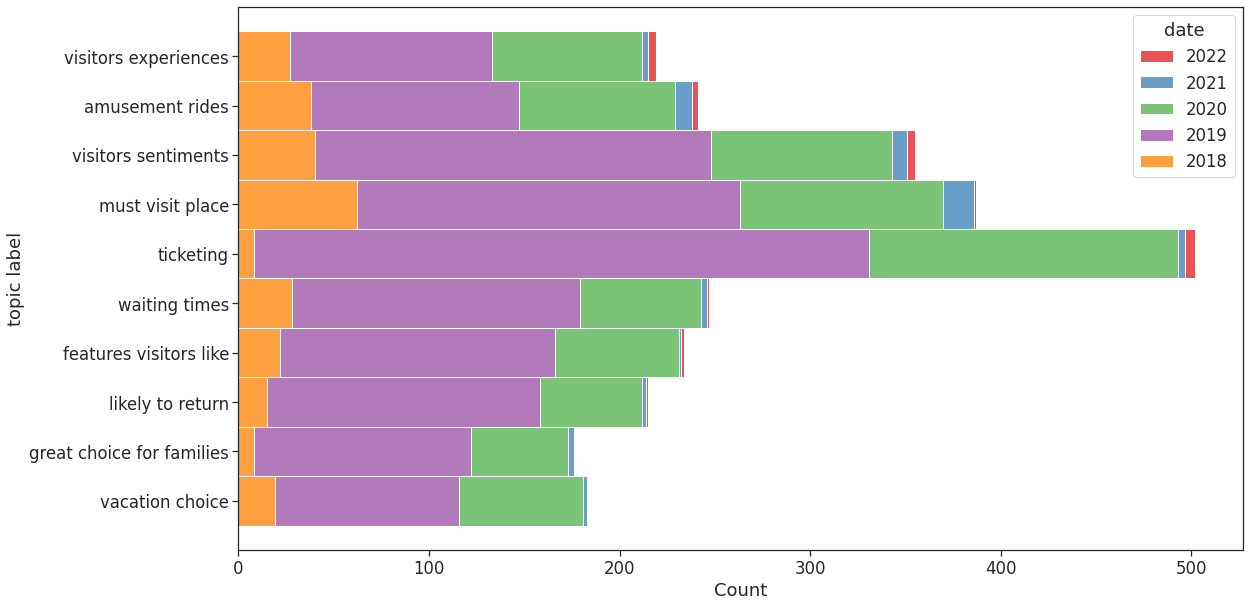

In [81]:
plt.figure(figsize=(18,10))

hue_order = [2022, 2021, 2020, 2019, 2018]
sns.histplot(data=uss_topred, y="topic label", hue="date", hue_order=hue_order, multiple="stack", bins= 50, palette="Set1") 


# **10. Fine Tuning Topic Labels or Summarization Tool**


## **10a) Perform Keywords Search for User Defined Topic Labels Verification**
We are going to search for topics most similar to the word "enjoyable", "experience", "return back",  in Indonesian language; which is "menyenangkan" , "pengalaman", "kembali". 

Returns:

* topic_words:  For each topic the top 50 words are returned, in order of semantic similarity to topic.

* word_scores:  For each topic the cosine similarity scores of the top 50 words to the topic are returned.

* topic_scores:  For each topic the cosine similarity to the search keywords will be returned.

* topic_nums:  The unique index of every topic will be returned.

### **10a.1.  BI-GRAM Model**

In [ ]:
# GENERATE TOPIC WORDS FOR BI-GRAM MODEL WITH SEARCH KEYWORDS

topic_keywords_bi, keyword_scores_bi, topic_scores_bi, keytopic_nums_bi = topicMODEL_bi.search_topics(keywords=["kembali", "pengalaman", "menyenangkan"], num_topics=5, keywords_neg=["mahal", "panas", "membosankan"], reduced=True) 

print(f"Unique index of every topic returned: {keytopic_nums_bi} \n") 
print(f"Cosine similarity score of each Topic to the search keywords : {topic_scores_bi} \n")   

for count, (topicword_bi, wordscore_bi, topicscore_bi, topicnum_bi) in enumerate(zip(topic_keywords_bi, keyword_scores_bi, topic_scores_bi, keytopic_nums_bi)):
    print(f"{count+1}  Topic: {topicnum_bi}   ")
    print(f"Cosine Similarity Score of Topic relative to Search Words: {topicscore_bi} \n") 
    print(f"Topic Words : \n{topicword_bi} \n")
    # print(f"Cosine Similarity Score of Words relative to Topic :\n{wordscore_bi}\n")


Unique index of every topic returned: [9 5 1 4 2] 

Cosine similarity score of each Topic to the search keywords : [0.23854481 0.16142961 0.04387904 0.03512731 0.03184686] 

1  Topic: 9   
Cosine Similarity Score of Topic relative to Search Words: 0.23854480912496495 

Topic Words : 
['para wisatawan' 'destinasi wisata' 'great experience' 'tempat wisata'
 'buat liburan' 'untuk liburan' 'trip' 'liburan' 'wisatawan' 'travel'
 'liburan bersama' 'tujuan wisata' 'liburan keluarga' 'ingin berkunjung'
 'wisata yang' 'petualangan' 'mengunjungi tempat' 'untuk dikunjungi'
 'holiday with' 'have fun' 'mengunjungi universal' 'berkunjung'
 'wajib dikunjungi' 'dapat menikmati' 'adventure' 'holiday'
 'amazing place' 'kunjungan' 'wisata' 'visit' 'fun' 'bisa dinikmati'
 'sangat menyenangkan' 'bersenangsenang' 'pengunjung' 'sangat memuaskan'
 'nice place' 'fun and' 'musim liburan' 'sangat menghibur' 'di traveloka'
 'bisa menikmati' 'enjoy' 'tempatnya bagus' 'hari libur' 'tempat hiburan'
 'tempat rekreasi

### **10a.2.   TRI-GRAM Model**

In [ ]:
# GENERATE TOPIC WORDS FOR TRI-GRAM MODEL WITH SEARCH KEYWORDS

topic_keywords_tri, keyword_scores_tri, topic_scores_tri, keytopic_nums_tri = topicMODEL_tri.search_topics(keywords= ["kembali", "pengalaman", "menyenangkan"], num_topics=5, keywords_neg=["banyak orang", "mahal", "panas", "membosankan"], reduced=True) 

print(f"Unique index of every topic returned: {keytopic_nums_tri} \n") 
print(f"Cosine similarity score of each Topic to the search keywords : {topic_scores_tri} \n")  

for count, (topicword_tri, wordscore_tri, topicscore_tri, topicnum_tri) in enumerate(zip(topic_keywords_tri, keyword_scores_tri, topic_scores_tri, keytopic_nums_tri)):
    print(f"{count}  Topic: {topicnum_tri} ")
    print(f"Cosine Similarity Score of Topic relative to Search Words: {topicscore_tri} \n") 
    print(f"Topic Words : \n{topicword_tri} \n")
    # print(f"Cosine Similarity Score of Words relative to Topic :\n{wordscore_tri}\n")


Unique index of every topic returned: [9 5 1 0 2] 

Cosine similarity score of each Topic to the search keywords : [0.0879893  0.08587854 0.03204471 0.02836581 0.00153511] 

0  Topic: 9 
Cosine Similarity Score of Topic relative to Search Words: 0.08798929967736455 

Topic Words : 
['anakanak senang' 'untuk anak anak' 'buat anak anak' 'bawa anak kecil'
 'untuk anak' 'buat anakanak' 'anak kecil' 'buat anak'
 'pengalaman yang sangat menyenangkan' 'anak anak' 'have fun'
 'sangat menyenangkan' 'sangat menikmati' 'fun and'
 'tempat yang menyenangkan' 'fun' 'bawa anak' 'dapat menikmati'
 'pengalaman yang menyenangkan' 'bisa menikmati semua wahana' 'anakanak'
 'cocok untuk liburan keluarga' 'tempat yang sangat bagus'
 'bersenangsenang' 'taman hiburan' 'menyenangkan sekali'
 'untuk liburan keluarga' 'bisa menikmati' 'tempat hiburan yang'
 'sangat bahagia' 'sangat memuaskan' 'tempat hiburan' 'bisa dinikmati'
 'enjoy' 'sangat menghibur' 'dan hiburan' 'liburan bersama keluarga'
 'menyenangkan' 'a

## **10b) Semantic Search Documents by Keywords**
Search documents for content semantically similar.

In [ ]:
# Search Documents by Key Words with Bi-Gram Model
documents_bi, document_scores_bi, document_ids_bi = topicMODEL_bi.search_documents_by_keywords(keywords= ["kembali", "pengalaman", "menyenangkan"], num_docs=5, keywords_neg=["mahal", "panas", "membosankan"])

for count, (doc_bi, score_bi, doc_id_bi) in enumerate(zip(documents_bi, document_scores_bi, document_ids_bi)):
    print(f"{count}. Document: {doc_id_bi}, Score: {score_bi}")
    print("-----------")
    print(doc_bi)
    print("-----------")
    print()

0. Document: 2151, Score: 0.3960281700324918
-----------
good experience bakal balik lagi kesini
-----------

1. Document: 1888, Score: 0.352561590375684
-----------
good and fun experience with my family
-----------

2. Document: 1935, Score: 0.3454234471205856
-----------
pengalaman yang sangat menyenangkan semoga kapankapan akan kembali lagi ke uss
-----------

3. Document: 467, Score: 0.34471274153401693
-----------
good experience best sangat mudah senang
-----------

4. Document: 1566, Score: 0.32369637115099836
-----------
great best experience i ever had
-----------



In [ ]:
# Search Documents by Key Words with Tri-Gram Model
documents_tri, document_scores_tri, document_ids_tri = topicMODEL_tri.search_documents_by_keywords(keywords= ["kembali", "pengalaman", "menyenangkan"], num_docs=5, keywords_neg=["mahal", "panas", "membosankan"])

for count, (doc_tri, score_tri, doc_id_tri) in enumerate(zip(documents_tri, document_scores_tri, document_ids_tri)):
    print(f"{count}. Document: {doc_id_tri}, Score: {score_tri}")
    print("-----------")
    print(doc_tri)
    print("-----------")
    print()

0. Document: 2151, Score: 0.3960280816029347
-----------
good experience bakal balik lagi kesini
-----------

1. Document: 1888, Score: 0.35256163837061727
-----------
good and fun experience with my family
-----------

2. Document: 1935, Score: 0.345423459023146
-----------
pengalaman yang sangat menyenangkan semoga kapankapan akan kembali lagi ke uss
-----------

3. Document: 467, Score: 0.34471270151552336
-----------
good experience best sangat mudah senang
-----------

4. Document: 1566, Score: 0.3236963469228309
-----------
great best experience i ever had
-----------

